In [34]:
# BLOCK 1: modules needed for import
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from datetime import datetime, timedelta
from scipy.stats import lognorm
from datetime import datetime, timedelta
import matplotlib.dates as mdates
# MODULES NOT USED IN THE NOTEBOOK
# from multiprocessing import cpu_count
# import cProfile
# import pstats
# import io
# for some godforsaken reason, I could NOT knit into PDF from vscode(but html was a
# prevent lines from being cut off on the right after knitting
from IPython.core.display import HTML
HTML("""
<style>
.container { width:100% !important; }
.output_result { max-width:100% !important; }
.output_area pre { width:100% !important; }
</style>
""")


#MOTIVATION

Asian carp are invasive species that have altered ecosystems in the United States due to their
fast growth rate, high fecundity, and tolerance of a wide variety of environmental conditions.
While they have not invaded the Great Lakes yet, it seems to only be a matter of time. In this
project, I aim to model possible population growth of Silver Carp in the Great Lakes if they
were to suddenly appear at various locations across the Great Lakes. First, let's clean the
datasets obtained from the Government of Ontario...

In [35]:
# BLOCK 2: Dataset Cleaning

def process_lake_data(file_path, codes_to_keep, 
                      temp_column_name, oxygen_column_name, 
                      output_file_prefix):
    kms_per_radian = 6371.0088
    
    # Load the data
    lake_data = pd.read_csv(file_path)
    
    # Filter the DataFrame and drop unnecessary columns
    filtered_df = lake_data[lake_data['CODE'].isin(codes_to_keep)].drop(
        columns=["CRUISE_PLAN", "LAST_DATE_UPDATED", "SOUNDING", 
                 "DEPTH_TO", "SEQ_NO", "LATITUDE", "LONGITUDE", "PSN"]
    )
    
    # Sort by latitude and longitude
    filtered_df_sorted = filtered_df.sort_values(
        by=['LATITUDE_DD', "LONGITUDE_DD"])
    
    # Extract coordinates for clustering
    coords = filtered_df_sorted[['LATITUDE_DD', 
                                 'LONGITUDE_DD']]
    
    # Define epsilon (1 km) in radians for use in 
    # haversine formula
    epsilon = 1 / kms_per_radian
    
    # DBSCAN model
    db = DBSCAN(eps=epsilon, min_samples=20, 
                algorithm='ball_tree', metric='haversine')
    
    # Fit the model and predict clusters
    clusters = db.fit_predict(np.radians(coords))
    
    # Add the cluster labels to the sorted DataFrame
    filtered_df_sorted['cluster'] = clusters
    
    # calculated mean lat and long for each cluster
    cluster_coords = filtered_df_sorted.groupby('cluster')[['LATITUDE_DD', 
                                                            'LONGITUDE_DD']].mean().reset_index()

    # calculate average date of the year when temperatures are >= 15 degrees celcius; use copy of the filtered DataFrame to avoid 'SettingWithCopyWarning' when modifying it later.
    filtered_df_sorted['STN_DATE'] = pd.to_datetime(filtered_df_sorted['STN_DATE'], errors='coerce')
    temps_15_or_above = filtered_df_sorted[(filtered_df_sorted['FULL_NAME'] == "TEMPERATURE (OF WATER)") & 
                                        (filtered_df_sorted['VALUE'] >= 13)].copy()
    temps_15_or_above['DAY_OF_YEAR'] = temps_15_or_above['STN_DATE'].dt.dayofyear

    # Group the data by 'cluster' and calculate the mean 'day of year' for each cluster.
    # Averages the positions of dates within the year across all entries in each cluster, finds the "average day" within the year for when the temperature is >= 15 degrees Celsius.
    avg_day_of_year_per_cluster = temps_15_or_above.groupby('cluster')['DAY_OF_YEAR'].mean().reset_index()
    avg_day_of_year_per_cluster['AVG_DATE'] = avg_day_of_year_per_cluster['DAY_OF_YEAR'].apply(
        lambda x: (pd.Timestamp('2001-01-01') + pd.to_timedelta(x-1, unit='D')).strftime('%m/%d')
    )

    # Calculate dissolved oxygen stats for summer months (as summertime contains the lowest dissolved oxygen levels in the year)
    summer_oxygen_df = filtered_df_sorted[
        (filtered_df_sorted['FULL_NAME'] == "OXYGEN,CONCENTRATION DISSOLVED") & 
        (filtered_df_sorted['STN_DATE'].dt.month.isin([7, 8, 9]))
    ]
    oxygen_stats = summer_oxygen_df.groupby('cluster')['VALUE'].agg(['mean', 'min', 'max']).reset_index()
    oxygen_stats.rename(columns={'mean': 'AVG_OXYGEN', 'min': 'MIN_OXYGEN', 'max': 'MAX_OXYGEN'}, inplace=True)

    # Step 5: Merge oxygen statistics with the mean latitude and longitude per cluster
    combined_stats_with_coords = pd.merge(cluster_coords, oxygen_stats, on='cluster', how='left')

    # add the average date column from `avg_date_numeric_per_cluster` to `combined_stats_with_coords`
    combined_stats_with_final = pd.merge(combined_stats_with_coords, avg_day_of_year_per_cluster, on='cluster', how='left')

    combined_stats_with_final.to_csv(f"{output_file_prefix}_combined_cluster_stats_with_coords.csv", index=False)

lake_data_files = ["Lake Superior Water Quality 2000-present.csv", 
             "Lake Erie Water Quality 2000-present.csv", 
             "Lake Huron Water Quality 2000-present.csv", 
             "Lake Ontario Water Quality 2000-present.csv",
             "Georgian Bay Water Quality 2000-present.csv"]

for file_path in lake_data_files:
    lake_name = file_path.split()[1].lower()
    process_lake_data(
    file_path=file_path,
    codes_to_keep=[100,245,90],
    temp_column_name="TEMPERATURE (OF WATER)",
    oxygen_column_name="OXYGEN,CONCENTRATION DISSOLVED",
    output_file_prefix=lake_name
    )

C:\Users\danie\AppData\Local\Temp\ipykernel_18276\1895490748.py:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  lake_data = pd.read_csv(file_path)
C:\Users\danie\AppData\Local\Temp\ipykernel_18276\1895490748.py:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  lake_data = pd.read_csv(file_path)
C:\Users\danie\AppData\Local\Temp\ipykernel_18276\1895490748.py:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  lake_data = pd.read_csv(file_path)


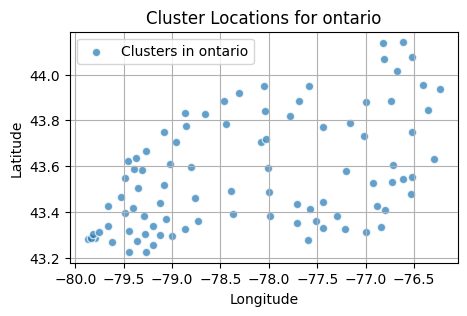

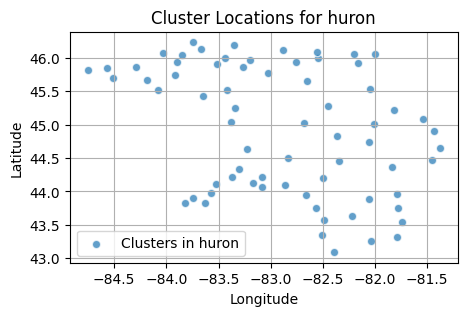

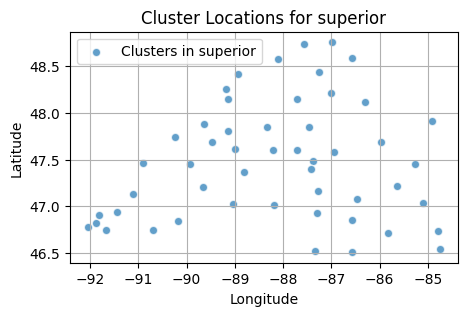

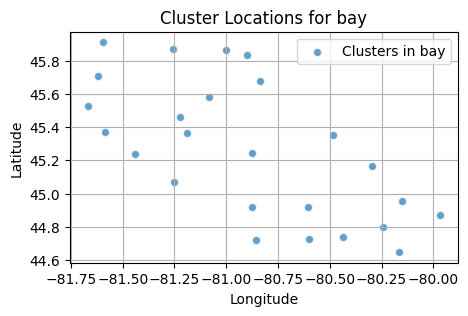

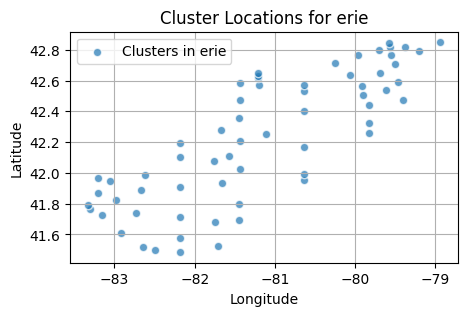

In [36]:

# BLOCK 3: Cluster Plotting
# Before we implement the model, lets look at where all the clusters are in each lake 
lake_data_with_coords = ['ontario_combined_cluster_stats_with_coords.csv',
                         'huron_20_year_simulation.csv',
                         'superior_combined_cluster_stats_with_coords.csv',
                         'bay_combined_cluster_stats_with_coords.csv',
                         'erie_combined_cluster_stats_with_coords.csv']
for lake_data in lake_data_with_coords:
    # generate a plot for each lake and look at all the clusters
    data = pd.read_csv(lake_data)
    # plot
    plt.figure(figsize=(5, 3))
    plt.scatter(data['LONGITUDE_DD'], data['LATITUDE_DD'], alpha=0.7, edgecolors='w', label=f'Clusters in {lake_data.split("_")[0]}')
    plt.title(f'Cluster Locations for {lake_data.split("_")[0]}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.show()

Now, lets see the distribution of when water temps reach or exceed 15 degrees in each lake,
which marks when reproduction would occur as well as dissolved average dissolved oxygen
levels, which impact survivability

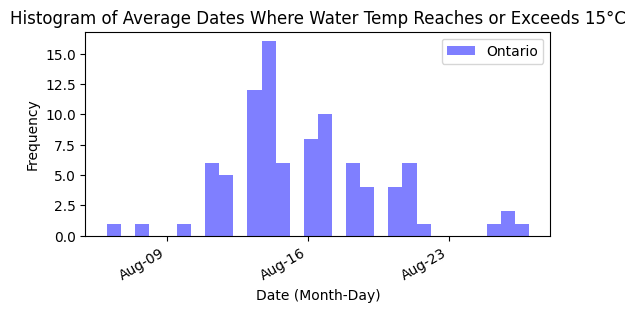

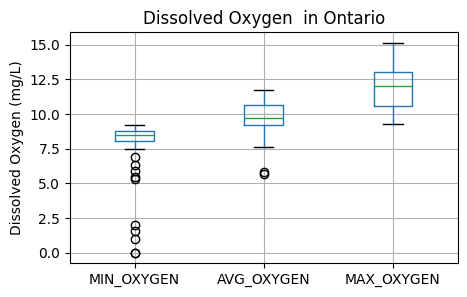

The overall average date when Ontario reaches or exceeds 15°C is: 08/14


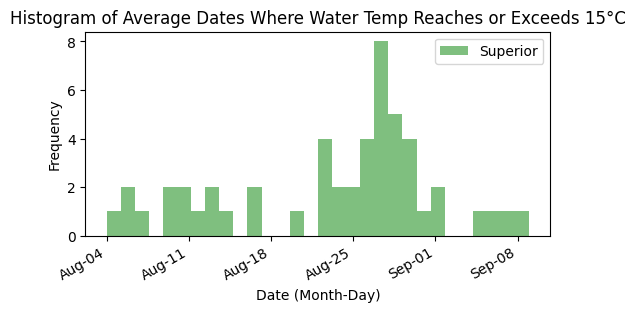

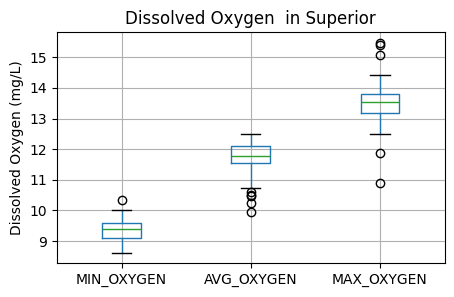

The overall average date when Superior reaches or exceeds 15°C is: 08/22


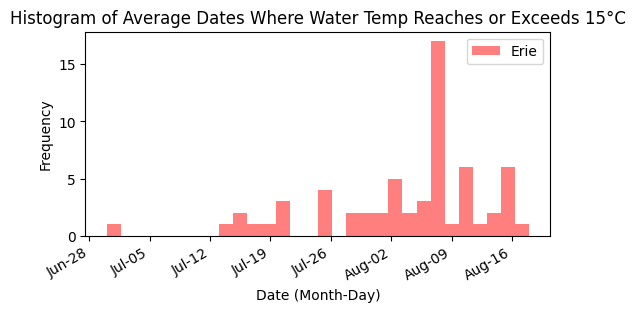

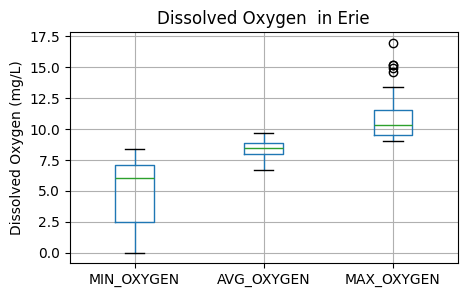

The overall average date when Erie reaches or exceeds 15°C is: 08/02


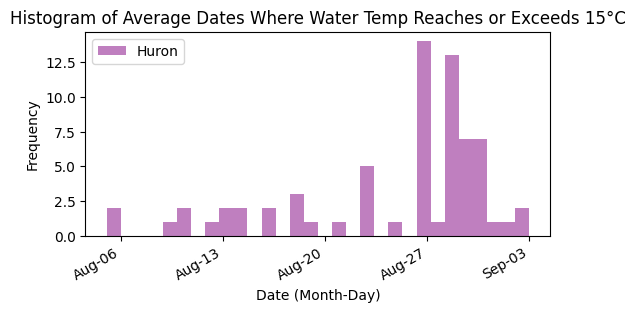

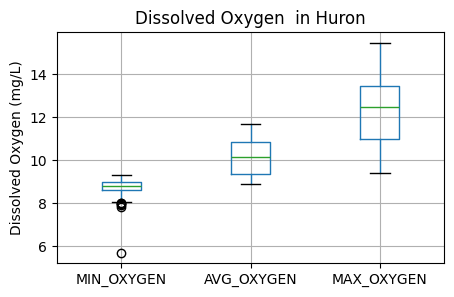

The overall average date when Huron reaches or exceeds 15°C is: 08/23


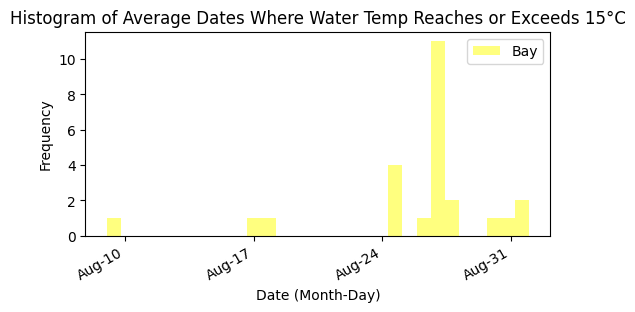

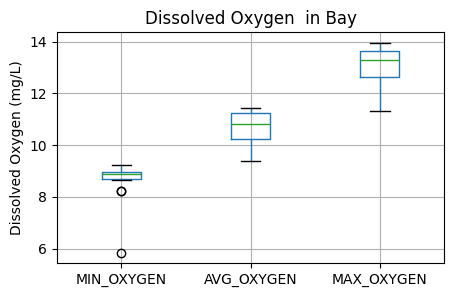

The overall average date when Bay reaches or exceeds 15°C is: 08/24


In [37]:
# BLOCK 4: Visualizations of Temperature and Dissolved oxygen

# List of CSV files and corresponding lake names
lake_files = [
    ("ontario_combined_cluster_stats_with_coords.csv", "Ontario", "blue"),
    ("superior_combined_cluster_stats_with_coords.csv", "Superior", "green"),
    ("erie_combined_cluster_stats_with_coords.csv", "Erie", "red"),
    ("huron_combined_cluster_stats_with_coords.csv", "Huron", "purple"),
    ("bay_combined_cluster_stats_with_coords.csv", "Bay", "yellow")
]

# using histograms, plot the dates where each cluster in each lake reaches >= 15 degrees
def plot_avg_date_histogram(csv_file, lake_name, color):
    lake_df = pd.read_csv(csv_file)
    # Since the year is not important, we use a dummy year for consistent parsing.
    lake_df['AVG_DATE'] = pd.to_datetime(lake_df['AVG_DATE'], format='%m/%d').dt.strftime('%m-%d')
    
    # Create a histogram for the AVG_DATE
    plt.figure(figsize=(6, 3))
    dates = [datetime.strptime(date, '%m-%d') for date in lake_df['AVG_DATE']]
    plt.hist(dates, bins=30, color=color, alpha=0.5, label=lake_name)

    # Set the formatter for the x-axis to show dates in 'Month-Day' format
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))  # Set interval to display every week
    plt.gcf().autofmt_xdate()  # Rotate the dates for better visibility

    plt.xlabel('Date (Month-Day)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Average Dates Where Water Temp Reaches or Exceeds 15°C')
    plt.legend()
    plt.show()

# calculates the overall date where the lake reaches the dates where temp exceeds 15 degrees
def calculate_overall_avg_date(csv_file, lake_name):
    lake_df = pd.read_csv(csv_file)
    # Parse the AVG_DATE column 
    lake_df['AVG_DATE'] = pd.to_datetime(lake_df['AVG_DATE'], format='%m/%d', errors='coerce')
    # Convert dates to day of the year for easier averaging
    lake_df['DAY_OF_YEAR'] = lake_df['AVG_DATE'].dt.dayofyear

    # Calculate the mean day of the year
    mean_day = lake_df['DAY_OF_YEAR'].mean()
    # Convert this day of the year back to a date; using a non-leap year for consistency
    overall_avg_date = datetime.strptime(f'2024-{int(mean_day)}', '%Y-%j').strftime('%m/%d')

    print(f"The overall average date when {lake_name} reaches or exceeds 15°C is: {overall_avg_date}")

# using box plots, showing the distribution of dissolved oxygen levels 
def plot_oxygen_distribution(csv_file, lake_name):
    lake_df = pd.read_csv(csv_file)
    oxygen_data = lake_df[['MIN_OXYGEN', 'AVG_OXYGEN', 'MAX_OXYGEN']]
    
    plt.figure(figsize=(5, 3))
    oxygen_data.boxplot()
    plt.ylabel('Dissolved Oxygen (mg/L)')
    plt.title(f'Dissolved Oxygen  in {lake_name}')
    plt.show()


# Plot a histogram for each lake
for csv_file, lake_name, color in lake_files:
    plot_avg_date_histogram(csv_file, lake_name, color)
    plot_oxygen_distribution(csv_file, lake_name)
    calculate_overall_avg_date(csv_file, lake_name)

From the plots, we see that on average, lake Erie reaches 15 degrees the earliest(~Average of August 2 of every year), followed by Ontario, Lake Superior, Lake Huron, and then Georgian Bay. Lake Erie also sees the lowest average dissolved oxygen as compared to the other Lakes; which makes sense, as it is the shallowest and warmest of theese Lakes. While Lake Erie's pattern was expected, overall the date at which all these Lakes exceed 15 degrees is a lot later within the season then I have expected; while big bodies of water take longer to warm up, I was expecting them to exceed 15 degrees in either June or July, not in August. Now, lets begin to build the model! First, let's deal with fecundity/number of eggs being laid...

12.37890799853647


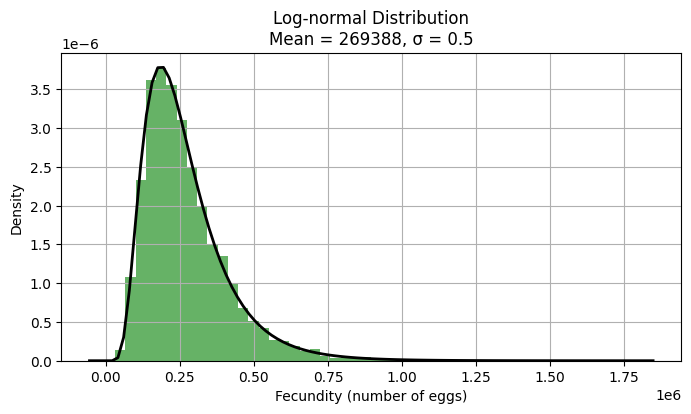

12.32390799853647


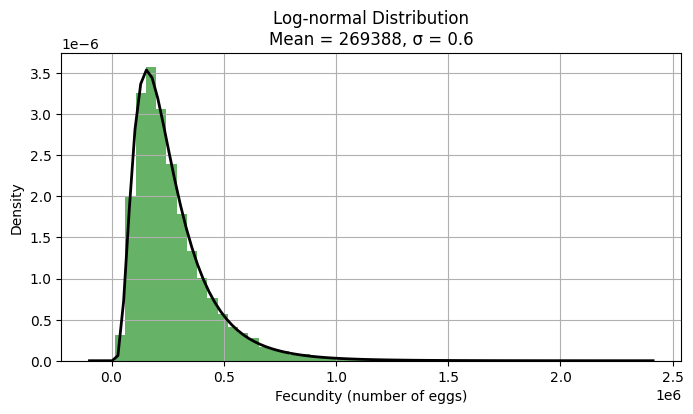

12.22265799853647


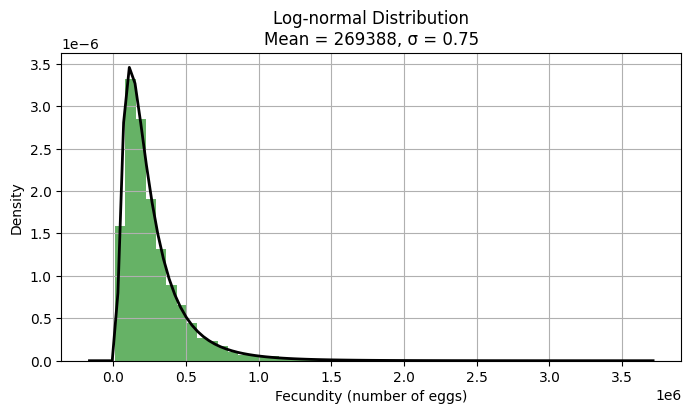

12.00390799853647


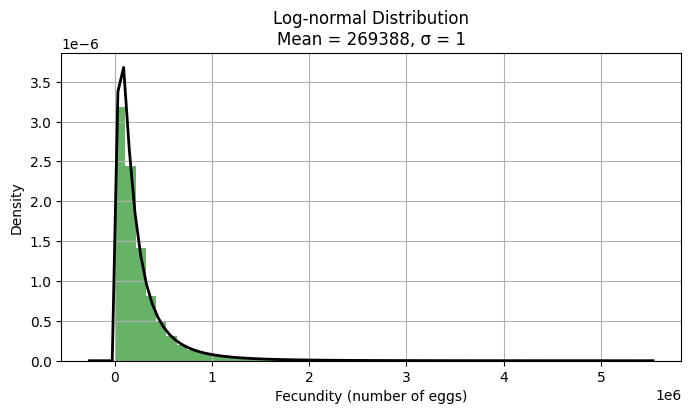

In [38]:
# Block 5: FECUNDITY DISTRIBUTION
# distribution for fecundity for use in the age-structured model
# From Williamson and Garvery 2005, female silver carp lay a clutch size of  26,650–3,683,150 eggs, with an average of around 269,388 eggs. Therefore, we want to determine a distribution that fits this range well, with a mean centered around the literature mean and very heavily right-skewed

# Function to plot the log-normal distribution based on sigma and target mean
def plot_lognormal_from_mean_sigma(target_mean, sigma, sample_size=10000):
    # Calculate mu from the target mean and sigma
    mu = np.log(target_mean) - (sigma**2 / 2)
    print(mu)
    # 12.37890799853647

    # Generate samples
    samples = np.random.lognormal(mean=mu, sigma=sigma, size=sample_size)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(8, 4))
    count, bins, ignored = ax.hist(samples, bins=50, density=True, alpha=0.6, color='g')
    
    # Try to fit line
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = lognorm.pdf(x, s=sigma, scale=np.exp(mu))
    ax.plot(x, p, 'k', linewidth=2)
    
    title = f"Log-normal Distribution\nMean = {target_mean}, σ = {sigma}"
    ax.set_title(title)
    ax.set_xlabel('Fecundity (number of eggs)')
    ax.set_ylabel('Density')
    plt.grid(True)
    plt.show()

# From literature, this was the average fecundity observed
target_mean = 269388

# Now, we test different sigma values to fit the taui 
sigma_values = [0.5, 0.6, 0.75, 1] 

# # Plot distributions for different sigma values
for sigma in sigma_values:
    plot_lognormal_from_mean_sigma(target_mean, sigma)
# sigma of 0.6 appears to be the best fit  

As seen from the plots, the plot with sigma of 0.6 best represents the distribution we would like to work with(majority of values centered around literature mean of 269388, but with a long right skew up to ~2 million)

In [39]:
#BLOCK 6: Stage-Structured Model

import logging
#logging.basicConfig(level=logging.DEBUG)  Formerly for debugging purposes 

# function that generates n number of values sampled from a log-normal distribution with the given inputs 
def fecundity_values(target_mean, sigma, n_needed):
    mu = np.log(target_mean) - (sigma**2 / 2)
    # formally a big bottleneck; instead of generating just value, generate n_needed number of lognormal values instead of calling this function multiple times for each run
    return np.random.lognormal(mean=mu, sigma=sigma, size=n_needed) 


# Utilizing a 3-Stage Structured Model(egg, juveniles, adults). For each cluster, and each run of "simulate_year()", we will 
# 1) Determine this year's recruitment(sampled from log-normal distribution); this is the number of eggs produced. Then, 80% are fertilized and hatched, then 0.1 percent survive to become year juveniles
# 2) Age juveniles; for each current age group(1,2,3,4,5), increment by 1. Age 5 juveniles become adults
# 3) Calculate Survivability: In function calculate_survival(). From literature, around 85% of population successfully overwinters; split this up randomly between adults and juveniles. Since Adults have more body mass, they are more likely to survive. 
#    used a uniform distribution and sample a value between 0.5 and 0.7 for more adult surviability of this 85%. Also get a dissolved oxygen level reading; sampled from a normal distribution's that was determined by the current cluster's historical  
#    dissolved oxygen range. Any value below 7 mg/L of dissolved oxygen increases mortality. Furthermore, juvenile mortality is also impacted by "degree days," or number of days that are above >5 degres where juveniles grow. 
#    Since bodies of water take longer to warm up and cool down, the last degree days were determined to be when temperature of lakes drop below this value (November 30). For this simulation, juveniles require at least 110 days since 
#    the reproductive event, otherwise mortality also increases 10% for every 10 days less than 110 as the juveniles do not have enough time to put on mass. Date of reproductive event was determined by the cluster's average date when temperatures exceed 15 degrees, 
#    with stochasticity of +=10 days of that date
# 4) With survival values, update the population, and get the population number of this year
# 5) Repeat for desired number of years 
 
# initialize the population for given dataset and cluster 
class Population_Model:
    def __init__(self, cluster_data, cluster_id, starting_adult_pop, simulation_years):
        self.cluster_id = cluster_id
        self.eggs = 0
        self.adults = starting_adult_pop  #D Starting number of mature adults that have magically appeared at the site
        self.cluster_conditions = cluster_data[cluster_data['cluster'] == self.cluster_id].iloc[0]
        self.current_year = 0
        self.fecundity_values = fecundity_values(269388, 0.6, simulation_years)
        self.juveniles_by_age = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}

        # precompute first_15_degree_day and oxygen values instead of being ran as a loop within simulate_year; more efficient and takes less time
        self.precomputed_oxygen = []
        self.first_15_degree_day = []
        avg_date_str = self.cluster_conditions['AVG_DATE']
        # Convert to datetime object, assuming a non-leap year
        avg_date = datetime.strptime(avg_date_str + ' 2024', '%m/%d %Y') 
        for _ in range(simulation_years):
            # Apply variability of ±10 days
            variability = random.randint(-10, 10)
            adjusted_date = avg_date + timedelta(days=variability)
            self.first_15_degree_day.append(adjusted_date)
            
            oxygen_std = self.estimate_std(self.cluster_conditions['MIN_OXYGEN'], 
                                           self.cluster_conditions['MAX_OXYGEN'])
            if oxygen_std == -1:
                self.precomputed_oxygen.append(self.cluster_conditions['AVG_OXYGEN'])
            else:
                self.precomputed_oxygen.append(np.random.normal(self.cluster_conditions['AVG_OXYGEN'], oxygen_std))
        self.yearly_adults = []
        self.yearly_juveniles = {1: [], 2: [], 3: [], 4: [], 5: []}
        self.yearly_eggs = []
        self.simulation_years = simulation_years

    # Returns the number of days from first date where water temps are >=15 to November 30(end of growth season), this will impact juvenile survival
    def calculate_degree_days(self, year_index):
        start_date = self.first_15_degree_day[year_index]
        end_date = datetime(start_date.year, 11, 30)
        return (end_date - start_date).days

    
    def estimate_std(self, min_val, max_val):
        # assume distribution is approximately normal; with 95% of data between 2 stan deviations
        # if the cluster does not have a different min/max value, return -1
        if max_val != min_val:
            return (max_val - min_val)/4 
        else:
            return -1
    
    # running the model on a cluster for a given year 
    def simulate_year(self):
        self.current_year += 1
        
        # For fecundity, assume half of adult population are females
        self.eggs += self.fecundity_values[self.current_year-1] * int(self.adults/2)

        # Juvenile age 1: from literature, 80% of eggs are fertilized successfully and hatch, then around 0.1 percent survive to become fry/juveniles 
        new_juveniles = np.round(self.eggs * 0.80 * 0.001)

        # calculate survival rates of juveniles and adults 
        self.calculate_survival(self.precomputed_oxygen[self.current_year-1], self.calculate_degree_days(self.current_year-1)) 
        
        # transition of juveniles to the next age and becoming adults
        new_adults = self.juveniles_by_age[5]
        for age in reversed(range(1,6)):
        # reverse the order so that we wont incorrectly increment an age group more than once
            if age == 5:
                # age 5 becoming adults
                self.adults += new_adults
                self.yearly_juveniles[age].append(new_adults)
                # assume all juveniles at this age have now become adults; reset it
                self.juveniles_by_age[age] = 0
            else:
                # all juveniles move up one year
                self.juveniles_by_age[age+1] = self.juveniles_by_age[age]

                self.yearly_juveniles[age].append(self.juveniles_by_age[age])

        # new juveniles(that hatched this year) now enter first age group
        self.juveniles_by_age[1] = new_juveniles
        self.yearly_juveniles[1].append(new_juveniles)

        self.eggs = 0
        self.yearly_adults.append(self.adults)
    
    # Calculate the survival rate (of adults and juveniles) of the current model 
    def calculate_survival(self, oxygen_level, degree_days_achieved):
        # calculate survival of juveniles; split the 85% winter surviability between adults and juveniles, but juveniles have the minimal survival rate;
        # if dissolved oxygen level is <7 mg/L, then mortality increases as metabolism breaks down (Hogue and Pegg, 2009)
        total_survival_rate = 0.85
        adult_survival_portion = random.uniform(0.5, 0.7)
        adult_survival_rate = total_survival_rate * adult_survival_portion
        juvenile_survival_rate = total_survival_rate * (1 - adult_survival_portion)
        
        # mortality increase if oxygen level is below 7mg/L
        if oxygen_level < 7:
            mortality_increase = (7-oxygen_level)*0.1
        else:
            mortality_increase = 0
        #adjusted survival rates based on oxygen levels 
        adjusted_adult_survival = max(0, adult_survival_rate - mortality_increase)
        adjusted_juvenile_survival = max(0, juvenile_survival_rate - mortality_increase)

        # juveniles require at least 110 growing degree days from first date of >=15 degrees until November 30; mortality increases by 10% for each 10 days short
        if degree_days_achieved < 110:
            days_short = 110 - degree_days_achieved
            mortality_increase_due_to_temp = (days_short // 10) * 0.1
            adjusted_juvenile_survival = max(0, adjusted_juvenile_survival - mortality_increase_due_to_temp)

        # Apply adjusted survival rates
        for age in reversed(range(1, 6)):
            if age == 5:
                # Transition age 5 juveniles to adults before applying survival rates
                new_adults = self.juveniles_by_age[age]
                self.adults += new_adults
                self.juveniles_by_age[age] = 0
            else:
                # Apply juvenile survival rate and age juveniles
                self.juveniles_by_age[age + 1] = np.round(self.juveniles_by_age[age] * adjusted_juvenile_survival)

        # Apply adult survival rate
        self.adults = np.round(self.adults * adjusted_adult_survival)

        # Prepare for new juveniles from this year's eggs, resetting the youngest juveniles
        self.juveniles_by_age[1] = 0

    def total_adult_population(self):
        return self.adults

In [40]:
# Using multiprocessing to speed up simulating each cluster in each lake dataset
# Note: for some reason, this block does not run properly in a jupyter/ipynb environment; this block was run as a standalone python script(final_stage_structured_py); please refer to that .py file for 
# a working edition

# def simulate_cluster(cluster_data, cluster_id, year):
#     profiler = cProfile.Profile()
#     profiler.enable()
#     model = Population_Model(cluster_data, cluster_id, 20, year)
#     for _ in range(year):
#         model.simulate_year()

#     profiler.disable()
#     s=io.StringIO()
#     stats = pstats.Stats(profiler, stream=s).sort_stats('time')
#     stats.print_stats()
#     return cluster_id, model.total_adult_population(), s.getvalue()

# # Using multiprocessing to simulate each cluster
# if __name__ == '__main__':
#     # Load cluster data and iterate over each lake dataset
#     lake_datasets = [
#         "superior_combined_cluster_stats_with_coords.csv",
#         "ontario_combined_cluster_stats_with_coords.csv",
#         "bay_combined_cluster_stats_with_coords.csv",
#         "erie_combined_cluster_stats_with_coords.csv",
#         "huron_combined_cluster_stats_with_coords.csv"
#     ]
    
    # for dataset in lake_datasets:
    #     cluster_data = pd.read_csv(dataset)
    #     cluster_ids = cluster_data['cluster'].tolist()
    #     lake_name = dataset.split('_')[0]  # Extract lake name from filename
    #     print(f"Processing {lake_name}...")
        
    #     with concurrent.futures.ProcessPoolExecutor(max_workers=cpu_count()) as executor:
    #         future_to_cluster = {executor.submit(simulate_cluster, cluster_data, cluster_id, 20): cluster_id for cluster_id in cluster_ids}
            
    #         for future in concurrent.futures.as_completed(future_to_cluster):
    #             cluster_id = future_to_cluster[future]
    #             try:
    #                 cluster_id, final_pop, profile_stats = future.result()
    #                 cluster_data.loc[cluster_data['cluster'] == cluster_id, '20_year_pop'] = final_pop
    #             except Exception as exc:
    #                 print(f'Cluster {cluster_id} generated an exception: {exc}')
        
    #     # Save the updated DataFrame with the lake name at the beginning of the filename
    #     output_filename = f"{lake_name}_20_year_simulation.csv"
    #     cluster_data.to_csv(output_filename, index=False)

# DATA ANALYSIS AND RESULTS
After running the simulation/model on each lake's datasets, let's analyze the results. Based
on literature, dissolved oxygen levels and temperatures are both limiting factors on silver
carp surviviability; I hypothesize that Lake Ontario or Lake huron would have the highest
populations of carp, as these two lakes should have an extended warm season as compared
to Lake Huron/Georgian Bay or Lake Superior, but are also deeper and would contain more
dissolved oxygen than lake erie. Let's see if we witness this result.

File name is ontario_20_year_simulation.csv
['cluster', 'LATITUDE_DD', 'LONGITUDE_DD', 'AVG_OXYGEN', 'MIN_OXYGEN', 'MAX_OXYGEN', 'DAY_OF_YEAR', 'AVG_DATE', '20_year_pop']
the avg_pop for Ontario is: 157688.72527472526

the total_pop for Ontario is: 14349674.0

File name is superior_20_year_simulation.csv
['cluster', 'LATITUDE_DD', 'LONGITUDE_DD', 'AVG_OXYGEN', 'MIN_OXYGEN', 'MAX_OXYGEN', 'DAY_OF_YEAR', 'AVG_DATE', '20_year_pop']
the avg_pop for Superior is: 98504.54901960785

the total_pop for Superior is: 5023732.0

File name is erie_20_year_simulation.csv
['cluster', 'LATITUDE_DD', 'LONGITUDE_DD', 'AVG_OXYGEN', 'MIN_OXYGEN', 'MAX_OXYGEN', 'DAY_OF_YEAR', 'AVG_DATE', '20_year_pop']
the avg_pop for Erie is: 165179.3492063492

the total_pop for Erie is: 10406299.0

File name is huron_20_year_simulation.csv
['cluster', 'LATITUDE_DD', 'LONGITUDE_DD', 'AVG_OXYGEN', 'MIN_OXYGEN', 'MAX_OXYGEN', 'DAY_OF_YEAR', 'AVG_DATE', '20_year_pop']
the avg_pop for Huron is: 57425.97101449275

the total_po

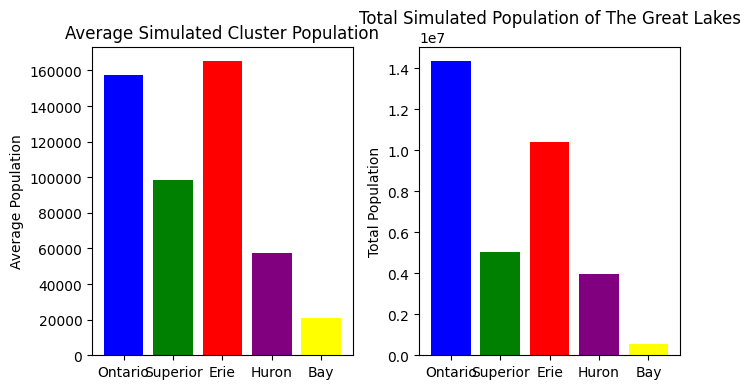

In [41]:
# To visualize Average populations in each cluster(within each lake), as well as the total simulated population in each lake
def plot_population_statistics(lake_files):
    avg_populations = []
    total_populations = []
    lake_names = []

    plt.figure(figsize=(7, 4))

    for file_name, lake_name, _ in lake_files:
        print(f"File name is {file_name}")
        df = pd.read_csv(file_name)
        cols_list = df.columns.tolist()
        print(cols_list)
        avg_pop = df['20_year_pop'].mean()
        print(f"the avg_pop for {lake_name} is: {avg_pop}\n")
        total_pop = df['20_year_pop'].sum()
        print(f"the total_pop for {lake_name} is: {total_pop}\n")
        avg_populations.append(avg_pop)
        total_populations.append(total_pop)
        lake_names.append(lake_name)

    # Plotting average populations
    plt.subplot(1, 2, 1)
    plt.bar(lake_names, avg_populations, color=['blue', 'green', 'red', 'purple', 'yellow'])
    plt.title('Average Simulated Cluster Population')
    plt.ylabel('Average Population')

    # Plotting total populations
    plt.subplot(1, 2, 2)
    plt.bar(lake_names, total_populations, color=['blue', 'green', 'red', 'purple', 'yellow'])
    plt.title('Total Simulated Population of The Great Lakes')
    plt.ylabel('Total Population')

    plt.tight_layout()
    plt.show()

# List of CSV files and corresponding lake names with color for plotting
lake_files = [
    ("ontario_20_year_simulation.csv", "Ontario", "blue"),
    ("superior_20_year_simulation.csv", "Superior", "green"),
    ("erie_20_year_simulation.csv", "Erie", "red"),
    ("huron_20_year_simulation.csv", "Huron", "purple"),
    ("bay_20_year_simulation.csv", "Bay", "yellow")
]

plot_population_statistics(lake_files)

From the plots, we can see that our warmest lakes (Ontario and Erie) both have the highest simulated average cluster populations, as well as the highest total simulated populations, while our colder and deeper lakes (Superior, Huron, and Georgian Bay) have far smaller populations. This was contrary to my original hypothesis; Lake Huron actually sees the second-lowest total population and average population in each cluster. Let's see if this is influenced by temperature or dissolved oxygen...

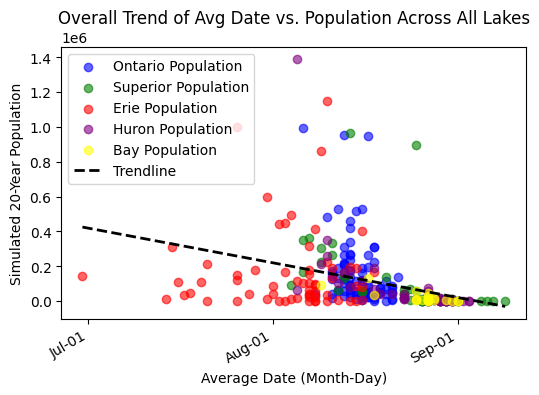

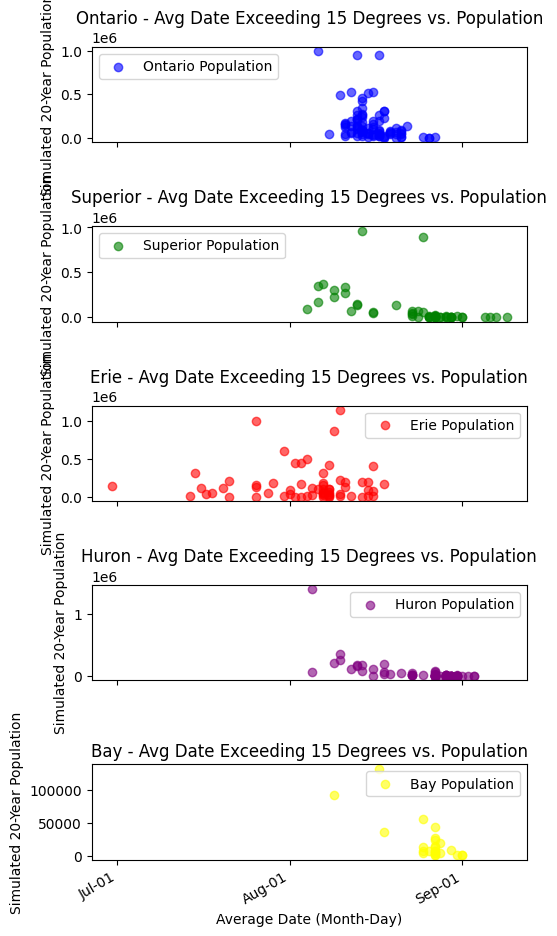

In [42]:
from sklearn.linear_model import LinearRegression
import datetime

# With the total simulated populations in mind, now let's see average population sizes with first onset of temperatures >=15 degrees, corresponding with total growing degree days, and try to use a
# linear regression model
def plot_combined_avg_date_vs_population_with_trendline(lake_files):
    fig, ax = plt.subplots(figsize=(6, 4))

    # Store all dates and populations for trendline calculation
    all_dates = []
    all_populations = []

    for file_name, lake_name, color in lake_files:
        df = pd.read_csv(file_name)
        # Convert AVG_DATE to datetime format
        df['AVG_DATE'] = pd.to_datetime('2024-' + df['AVG_DATE'], format='%Y-%m/%d', errors='coerce')
        df['DayOfYear'] = df['AVG_DATE'].dt.dayofyear

        ax.scatter(df['AVG_DATE'], df['20_year_pop'], color=color, alpha=0.6, label=f"{lake_name} Population")

        # Collect data for trendline
        all_dates.extend(df['DayOfYear'])
        all_populations.extend(df['20_year_pop'])

    # Convert date and population data for trendline calculation
    X = np.array(all_dates).reshape(-1, 1)
    y = np.array(all_populations)
    
    # Fit linear regression model
    model = LinearRegression().fit(X, y)
    trendline = model.predict(X)

    # Sort dates and corresponding trendline values
    sorted_idx = np.argsort(X.flatten())
    sorted_dates = np.array(all_dates)[sorted_idx]
    sorted_trendline = trendline[sorted_idx]

    # Convert sorted day of year back to date format for plotting
    sorted_dates = [datetime.datetime(2024, 1, 1) + datetime.timedelta(days=int(day - 1)) for day in sorted_dates]
    ax.plot(sorted_dates, sorted_trendline, color="black", linewidth=2, linestyle="--", label='Trendline')

    # Formatting plot
    ax.set_xlabel('Average Date (Month-Day)')
    ax.set_ylabel('Simulated 20-Year Population')
    ax.set_title('Overall Trend of Avg Date vs. Population Across All Lakes')
    ax.legend()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    plt.gcf().autofmt_xdate()
    plt.show()

# Visualizing each lake separately
def plot_individual_lake_avg_date_vs_population(lake_files):
    num_lakes = len(lake_files)
    fig, axes = plt.subplots(nrows=num_lakes, figsize=(6, num_lakes * 2), sharex=True)

    if num_lakes == 1:
        axes = [axes]  

    for ax, (file_name, lake_name, color) in zip(axes, lake_files):
        df = pd.read_csv(file_name)
        # Convert AVG_DATE to datetime format for consistency
        df['AVG_DATE'] = pd.to_datetime('2024-' + df['AVG_DATE'], format='%Y-%m/%d', errors='coerce')

        ax.scatter(df['AVG_DATE'], df['20_year_pop'], color=color, alpha=0.6, label=f"{lake_name} Population")
        ax.set_title(f'{lake_name} - Avg Date Exceeding 15 Degrees vs. Population')
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
        ax.set_ylabel('Simulated 20-Year Population')
        ax.legend()

    plt.gcf().autofmt_xdate()  # Rotate dates to prevent overlap
    plt.xlabel('Average Date (Month-Day)')
    fig.tight_layout(pad=3.0)
    plt.show()

plot_combined_avg_date_vs_population_with_trendline(lake_files)
plot_individual_lake_avg_date_vs_population(lake_files)

Overall, we can see that there is a slight negative relationship with how late the first day that exceeds 15 degrees is and the resultant simulated population. From our previous analysis on strictly populations, the lakes with the highest populations(lake Erie and Lake Ontario), we see more clusters that reach 15 degrees earlier within the year. This makes sense, as the juveniles in these clusters would have longer duration to grow and put on size to overwinter. Perhaps dissolved oxygen has less of an effect as compared to onset of warm temperatures? Let's try to see the relationship with dissolved oxygen...

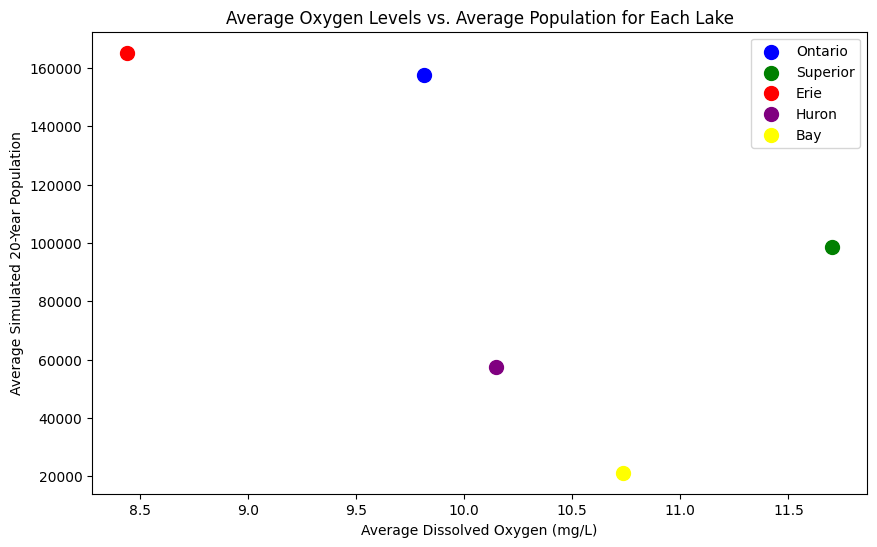

In [43]:
# visualize Average dissolved oxygen levels during the summer (mg/L) and population
def plot_avg_oxygen_vs_avg_population(lake_files):
    avg_oxygens = []
    avg_populations = []
    lake_names = []

    plt.figure(figsize=(10, 6))

    for file_name, lake_name, color in lake_files:
        df = pd.read_csv(file_name)
        avg_oxygen = df['AVG_OXYGEN'].mean()
        avg_pop = df['20_year_pop'].mean()

        avg_oxygens.append(avg_oxygen)
        avg_populations.append(avg_pop)
        lake_names.append(lake_name)

        plt.scatter(avg_oxygen, avg_pop, label=lake_name, color=color, s=100)

    plt.xlabel('Average Dissolved Oxygen (mg/L)')
    plt.ylabel('Average Simulated 20-Year Population')
    plt.title('Average Oxygen Levels vs. Average Population for Each Lake')
    plt.legend()
    plt.show()
plot_avg_oxygen_vs_avg_population(lake_files)

We see that dissolved oxygen does not really seem to impact population in the way I originally thought. In fact, this plot is suggesting that a lower average dissolved oxygen level is more idea for population. Let's try visualizing both onset of warm temperatures and dissolved oxygen together with population count...

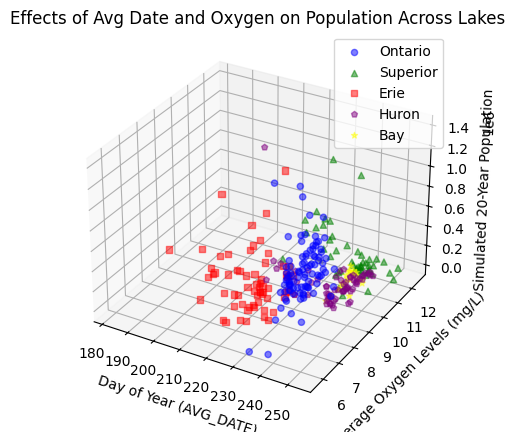

In [44]:
from mpl_toolkits.mplot3d import Axes3D
# Let's try to visualize average dissolved oxygen levels + Date when temp >= 15 on Population
def plot_3d_avg_date_oxygen_population(lake_files):
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111, projection='3d')
    markers = ['o', '^', 's', 'p', '*']
    for (file_name, lake_name, color), marker in zip(lake_files, markers):
        df = pd.read_csv(file_name)
        # Convert AVG_DATE to numerical day of year
        df['AVG_DATE'] = pd.to_datetime('2024-' + df['AVG_DATE'], format='%Y-%m/%d', errors='coerce')
        df['DayOfYear'] = df['AVG_DATE'].dt.dayofyear

        # Scatter plot
        xs = df['DayOfYear']
        ys = df['AVG_OXYGEN']
        zs = df['20_year_pop']
        ax.scatter(xs, ys, zs, color=color, alpha=0.5, label=f"{lake_name}", marker=marker)

    # Labels and title
    ax.set_xlabel('Day of Year (AVG_DATE)')
    ax.set_ylabel('Average Oxygen Levels (mg/L)')
    ax.set_zlabel('Simulated 20-Year Population')
    ax.set_title('Effects of Avg Date and Oxygen on Population Across Lakes')

    # Legend
    ax.legend()

    # Show plot
    plt.show()

plot_3d_avg_date_oxygen_population(lake_files)

Besides showing the densest cluster of points around 220-230(around mid/late August), we did not really see any meaningful relationships between the three variables. Let's try using a correlation matrix instead...

In [45]:

lake_data_with_info = [
    ("ontario_20_year_simulation.csv", "Ontario", "blue"),
    ("superior_20_year_simulation.csv", "Superior", "green"),
    ("erie_20_year_simulation.csv", "Erie", "red"),
    ("huron_20_year_simulation.csv", "Huron", "purple"),
    ("bay_20_year_simulation.csv", "Bay", "yellow")
]

def process_correlation(lake_file_info):
    file_name, lake_name, color = lake_file_info
    data = pd.read_csv(file_name)

    # Convert AVG_DATE from string to datetime and then get the day of the year
    data['AVG_DATE'] = pd.to_datetime(data['AVG_DATE'], errors='coerce', format='%m/%d').dt.dayofyear
    data['AVG_OXYGEN'] = pd.to_numeric(data['AVG_OXYGEN'], errors='coerce')

    # Drop any rows that have NaN values after conversion
    data = data.dropna(subset=['AVG_DATE', 'AVG_OXYGEN', '20_year_pop'])

    # Calculate the correlation matrix
    correlation_matrix = data[['AVG_DATE', 'AVG_OXYGEN', '20_year_pop']].corr()

    print(f"Correlation matrix for {lake_name}:")
    print(correlation_matrix, "\n")

for lake_info in lake_data_with_info:
    process_correlation(lake_info)

Correlation matrix for Ontario:
             AVG_DATE  AVG_OXYGEN  20_year_pop
AVG_DATE     1.000000   -0.445224    -0.354730
AVG_OXYGEN  -0.445224    1.000000     0.151664
20_year_pop -0.354730    0.151664     1.000000 

Correlation matrix for Superior:
             AVG_DATE  AVG_OXYGEN  20_year_pop
AVG_DATE     1.000000   -0.147118     -0.48657
AVG_OXYGEN  -0.147118    1.000000      0.20350
20_year_pop -0.486570    0.203500      1.00000 

Correlation matrix for Erie:
             AVG_DATE  AVG_OXYGEN  20_year_pop
AVG_DATE     1.000000   -0.202595     0.012917
AVG_OXYGEN  -0.202595    1.000000     0.361272
20_year_pop  0.012917    0.361272     1.000000 

Correlation matrix for Huron:
             AVG_DATE  AVG_OXYGEN  20_year_pop
AVG_DATE     1.000000    0.549051    -0.597080
AVG_OXYGEN   0.549051    1.000000    -0.324964
20_year_pop -0.597080   -0.324964     1.000000 

Correlation matrix for Bay:
             AVG_DATE  AVG_OXYGEN  20_year_pop
AVG_DATE     1.000000    0.213178    -0.7

#CONCLUSIONS

From our model, it not only suggests that Silver Carp are able to establish in the Great lakes in a short time frame. Our simulation assumed only a starting population of 10 individuals in each cluster; depending on the environmental conditions, the cluster size can reach over a million in just 20 years. We compared environmental factors in literature that was suggested to impact Silver Carp survival: temperature and dissolved oxygen levels. While temperature appears to be correlated with population sizes, dissolved oxygen levels are a bit more complex. Overall, while Lake Ontario's population acted more accordently with what we predicted, it turns out Lake Erie, despite its low dissolved oxygen levels, did not appear to impact its population. 

Overall, this model is quite limited. The model also did not consider methods of dispersal, intermingling of populations, and competition/predation. All of these factors would greatly impact the successfulness of Silver Carp establishing. With a longer project frame, a bioenergetics model should be explored; food avabilibility/daily intake was not considered in this model. Furthermore, we also simplified the lifestyle of Silver carp; we did not consider the migratory lifestyle that silver carp undergo to spawn.

In all, this project is a proof-of-concept of a population growth; further research and
prevention methods should be explored to prevent these species from becoming
established in the Great Lakes and changing the delicate communities already present.


# Sources: (Not in apa format sorry)

Datasets(Government of Canada): https://datadonnees.az.ec.gc.ca/data/substances/monitor/great-lakes-water-quality-monitoring-andaquatic-ecosystem-health-data/great-lakes-water-quality-monitoring-and-surveillance-data/

Literature Sources: https://opensiuc.lib.siu.edu/cgi/viewcontent.cgi?
article=1002&context=fiaq_reports https://link.springer.com/article/10.1007/s10530-013-
0547-3 https://www.tandfonline.com/doi/abs/10.1080/02705060.2009.9664330
https://www.proquest.com/docview/2416728950/8931A92E447A4067PQ/2?
sourcetype=Scholarly%20Journals https://www.anglingtimes.co.uk/advice/tips/how-carpgrow-in-fish-farms/ http://www.carp-fishing-tactics.com/science-carpreproduction.html#:~:text=Carp%20generally%20spawn%20in%20April,and%20more%20than%2
